# Load Dependencies

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn import tree
from sklearn import linear_model
from sklearn.svm import SVR, LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor,BaggingRegressor
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error,r2_score
from scipy.stats import pearsonr
from script.feature_selection import circle
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
random_seed=2022

# Load Data

In [2]:
train_num=49
df_data=pd.read_excel('./Data/Data.xlsx')
ratio=np.array(df_data)[:,8][:train_num]
des_all=np.array(df_data)[:,9:]
ratio_log=np.array([np.log(i) for i in ratio])
des_max=des_all[:train_num,:].max(axis=0)
des_min=des_all[:train_num,:].min(axis=0)
des_all_std=(des_all-des_min)/(des_max-des_min)

In [3]:
df_data

,Unnamed: 0,reactant1,reactant2,set1,set2,n(r1)/n(r2),elecricity,T,ratio,8,...,25,26,27,28,29,30,31,32,33,34
0,0,CC1=CC=CC=C1,C=CC(OCCCC)=O,0,1,10,1,60,2.100000,1.702967,...,0.188588,0.674357,0.677398,0.969871,0.971426,1.081074,1.080450,-0.389886,-0.216763,2.479014
1,1,CC1=CC=CC=C1,C=CC(OCCCC)=O,0,2,10,1,60,1.909091,1.702967,...,0.189256,0.674357,0.677407,0.969871,0.971746,1.081074,1.080049,-0.389886,-0.216763,2.479014
2,2,CC1=CC=CC=C1,C=CC(OCCCC)=O,1,2,10,1,60,0.909091,1.703407,...,0.189256,0.677398,0.677407,0.971426,0.971746,1.080450,1.080049,-0.389886,-0.216763,2.479014
3,3,C12=CC=CC=C1C=CC=C2,C=CC(OCCCC)=O,0,1,5,1,60,2.800000,1.700055,...,0.189094,0.663741,0.666087,0.968543,0.971183,1.081061,1.080405,-0.377368,-0.257932,1.927644
4,4,ClC1=C(OC)C=CC=C1,C=CC(OCCCC)=O,0,1,10,1,60,0.625000,1.808682,...,0.189501,0.645294,0.665523,0.964724,0.970356,1.078336,1.079508,-0.382940,-0.236381,2.087947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,178,CC1=C(Cl)C=CC=C1Cl,C=CC(OCCCC)=O,0,2,5,1,60,NaN,1.716123,...,0.191708,0.647493,0.647493,0.966527,0.966527,1.078416,1.078416,-0.403884,-0.249023,2.647464
172,179,CC1=C(Cl)C=CC=C1Cl,C=CC(OCCCC)=O,1,2,5,1,60,NaN,1.732552,...,0.191708,0.649563,0.647493,0.967510,0.966527,1.078610,1.078416,-0.403884,-0.249023,2.647464
173,183,CC1=CC(C(C)(C)C)=CC(C(C)(C)C)=C1,C=CC(OCCCC)=O,0,1,5,1,60,NaN,3.247917,...,0.186582,0.659148,0.665309,0.959024,0.964251,1.076515,1.078161,-0.376850,-0.206119,2.135690
174,184,OCC1=CC=CC=C1CO,C=CC(OCCCC)=O,0,1,5,1,60,NaN,1.789384,...,0.188802,0.680891,16.434056,0.964429,0.970808,1.078049,1.079957,-0.390885,-0.225707,2.425742


# Model Selection

In [4]:
models = [BaggingRegressor(random_state=random_seed,n_jobs=60),
          tree.DecisionTreeRegressor(random_state=random_seed),
          ExtraTreesRegressor(random_state=random_seed,n_jobs=60),
          GradientBoostingRegressor(random_state=random_seed,),
          KNeighborsRegressor(n_jobs=60,),KernelRidge(),
          LinearSVR(random_state=random_seed,),RandomForestRegressor(random_state=random_seed,n_jobs=60),
          linear_model.Ridge(random_state=random_seed,alpha=.5),SVR(), 
          xgb.XGBRegressor(random_state=random_seed,n_jobs=60)]
model_names = ['BG','DT','ET','GB','KNR','KRR','LSVR','RF','Ridge','SVR','XGB']
descs = [des_all_std[0:train_num]]
desc_names = ['CD']

In [5]:
loo = LeaveOneOut()
performance_dict = {}
for desc,desc_name in zip(descs,desc_names): 
    desc_=desc
    Y_=np.array(ratio_log[:train_num])
    for model,model_name in zip(models,model_names):
        all_r2 = []
        all_pearsr = []
        all_mae = []
        repeat_pred = []
        repeat_test = []
        for i in range(1):
            all_pred = []
            all_test = []
            for train_index_tep,test_index_tep in loo.split(desc_):
                train_x,test_x = desc_[train_index_tep],desc_[test_index_tep]
                train_y,test_y = Y_[train_index_tep],Y_[test_index_tep]
                model.fit(train_x,train_y)
                test_pred = model.predict(test_x)
                all_pred.append(test_pred)
                all_test.append(test_y)
            all_pred = np.concatenate(all_pred)
            all_test = np.concatenate(all_test).reshape(-1)
            repeat_pred.append(all_pred)
            repeat_test.append(all_test)
        all_pred = np.mean(repeat_pred,axis=0)
        all_test = np.mean(repeat_test,axis=0)      
        r2 = r2_score(all_test,all_pred)
        pearsr = pearsonr(all_test,all_pred)[0]
        mae = mean_absolute_error(all_test,all_pred)           
        performance_dict['%s-%s'%(model_name,desc_name)] = [mae,r2,pearsr,all_pred,all_test]
        print('Model: %5s, Descriptor: %15s: R2: %.4f, MAE: %.4f, Pearson R: %.4f'%(
        model_name,desc_name,r2,mae,pearsr))

Model:    BG, Descriptor:              CD: R2: 0.5594, MAE: 0.7874, Pearson R: 0.7523
Model:    DT, Descriptor:              CD: R2: 0.5355, MAE: 0.7480, Pearson R: 0.7865
Model:    ET, Descriptor:              CD: R2: 0.6919, MAE: 0.6614, Pearson R: 0.8690
Model:    GB, Descriptor:              CD: R2: 0.6456, MAE: 0.6505, Pearson R: 0.8060
Model:   KNR, Descriptor:              CD: R2: 0.2430, MAE: 1.0390, Pearson R: 0.4994
Model:   KRR, Descriptor:              CD: R2: 0.5003, MAE: 0.7981, Pearson R: 0.7314
Model:  LSVR, Descriptor:              CD: R2: 0.5617, MAE: 0.7255, Pearson R: 0.7960
Model:    RF, Descriptor:              CD: R2: 0.5657, MAE: 0.7775, Pearson R: 0.7906
Model: Ridge, Descriptor:              CD: R2: 0.5396, MAE: 0.7693, Pearson R: 0.7357
Model:   SVR, Descriptor:              CD: R2: 0.2819, MAE: 0.9779, Pearson R: 0.6157
Model:   XGB, Descriptor:              CD: R2: 0.6738, MAE: 0.6330, Pearson R: 0.8303


<AxesSubplot:>

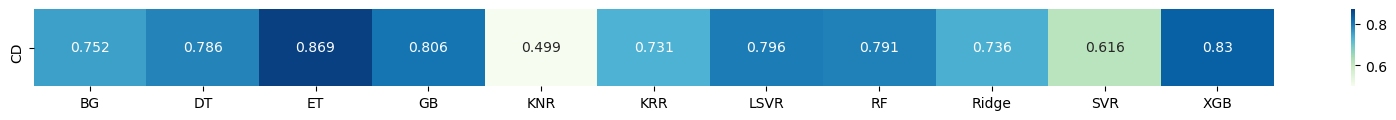

In [6]:
r2_map = np.zeros((len(desc_names),len(model_names)))
for i,m in enumerate(model_names):
    for j,d in enumerate(desc_names):
        r2_map[j,i] = performance_dict['%s-%s'%(m,d)][2]

fig = plt.figure(figsize=(20,1))
sns.heatmap(r2_map,annot=True,fmt='.3g',xticklabels=model_names,yticklabels=desc_names,cmap='GnBu')

Text(-4, 1.6, 'MAE: 0.661')

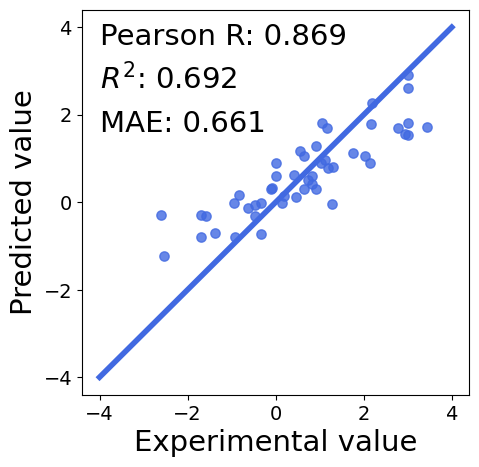

In [10]:
model = 'ET-CD'
train_y = performance_dict[model][4]
train_p = performance_dict[model][3]

colour='royalblue'
word=21
fig = plt.figure(figsize=(5,5))
plt.xticks([-4,-2,0,2,4],fontsize=14)
plt.yticks([-4,-2,0,2,4],fontsize=14)
plt.xlabel('Experimental value',fontsize=word)
plt.ylabel('Predicted value',fontsize=word)
plt.plot([-4,4],[-4,4],c=colour,linewidth=4)
plt.scatter(np.array(train_y),np.array(train_p),c=colour,s=45, alpha=0.8)
plt.text(-4,3.6,'Pearson R: %.3f'%pearsonr(np.array(train_y),np.array(train_p))[0],fontsize=word)
plt.text(-4,2.6,'$R^2$: %.3f'%(r2_score(np.array(train_y),np.array(train_p))),fontsize=word)
plt.text(-4,1.6,'MAE: %.3f'%mean_absolute_error(np.array(train_y),np.array(train_p)),fontsize=word)

# Descriptor Selection

In [9]:
des_sel_max=28
tem_des_sel=[]
max_pear,max_r2,max_mae,tem_des_sel_max=circle(des_all_std[0:train_num,:28],lable=ratio_log[0:train_num],model=ExtraTreesRegressor(random_state=random_seed,n_jobs=60),des_len=28,tem_des_sel=tem_des_sel)
print(max_pear,max_r2,max_mae,tem_des_sel_max)
result=[]
while True:
    tem_des_sel=tem_des_sel_max
    max_pear,max_r2,max_mae,tem_des_sel_max=circle(des_all_std[0:train_num,:28],lable=ratio_log[0:train_num],model=ExtraTreesRegressor(random_state=random_seed,n_jobs=60),des_len=28,tem_des_sel=tem_des_sel)
    result.append([max_pear,max_r2,max_mae,tem_des_sel_max])
    print(max_pear,max_r2,max_mae,tem_des_sel_max)
    if len(tem_des_sel_max) ==des_sel_max:
        break
    else:
        continue

[0.67749103] [0.39565286] 0.8866187511446957 [9]
[0.73973139] [0.54641744] 0.7636284087362525 [9, 11]
[0.84750324] [0.71416148] 0.6121257395338228 [9, 11, 5]
[0.88197588] [0.7617761] 0.5792974628204872 [9, 11, 5, 25]
[0.90475302] [0.79576454] 0.5373930378284405 [9, 11, 5, 25, 26]
[0.89083762] [0.75857043] 0.5718927663698044 [9, 11, 5, 25, 26, 18]
[0.91265678] [0.7924671] 0.518992096905494 [9, 11, 5, 25, 26, 18, 17]
[0.91464302] [0.80358488] 0.5251313557578099 [9, 11, 5, 25, 26, 18, 17, 16]
[0.91236126] [0.79991993] 0.5262725949601141 [9, 11, 5, 25, 26, 18, 17, 16, 21]
[0.90050863] [0.79004433] 0.5073576134005136 [9, 11, 5, 25, 26, 18, 17, 16, 21, 15]
[0.92724258] [0.81618797] 0.49820706701965933 [9, 11, 5, 25, 26, 18, 17, 16, 21, 15, 13]
[0.92553013] [0.81438572] 0.48788484605832044 [9, 11, 5, 25, 26, 18, 17, 16, 21, 15, 13, 24]
[0.90911629] [0.78517122] 0.5428021164413983 [9, 11, 5, 25, 26, 18, 17, 16, 21, 15, 13, 24, 8]
[0.91642049] [0.79697276] 0.5131536568545783 [9, 11, 5, 25, 26, 

# Prediction 

In [12]:
sel_index = [9, 11, 5, 25, 26, 18, 17, 16, 21, 15, 13, 24, 8, 19, 2]
des_sel=des_all_std[:train_num,sel_index]
ratio_log_train=ratio_log[0:train_num]
model = ExtraTreesRegressor(random_state=random_seed,n_jobs=60)
all_r2 = []
all_pearsr = []
all_mae = []
repeat_pred = []
repeat_test = []
for i in range(10):
    all_pred = []
    all_test = []
    for train_index_tep,test_index_tep in loo.split(des_sel):
        train_x,test_x = des_sel[train_index_tep],des_sel[test_index_tep]
        train_y,test_y = ratio_log_train[train_index_tep],ratio_log_train[test_index_tep] 
        model.fit(train_x,train_y)
        test_pred = model.predict(test_x)
        all_pred.append(test_pred)
        all_test.append(test_y)
    all_pred = np.concatenate(all_pred)
    all_test = np.concatenate(all_test).reshape(-1)
    repeat_pred.append(all_pred)
    repeat_test.append(all_test)
train_p = np.mean(repeat_pred,axis=0)
train_y = np.mean(repeat_test,axis=0)

# Results

Text(-4, 1.6, 'MAE: 0.536')

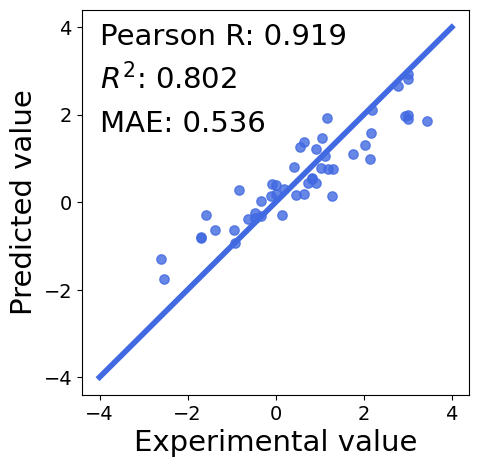

In [9]:
colour='royalblue'
word=21
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,5))
plt.xticks([-4,-2,0,2,4],fontsize=14)
plt.yticks([-4,-2,0,2,4],fontsize=14)
plt.xlabel('Experimental value',fontsize=word)
plt.ylabel('Predicted value',fontsize=word)
plt.plot([-4,4],[-4,4],c=colour,linewidth=4)
plt.scatter(np.array(train_y),np.array(train_p),c=colour,s=45, alpha=0.8)
plt.text(-4,3.6,'Pearson R: %.3f'%pearsonr(np.array(train_y),np.array(train_p))[0],fontsize=word)
plt.text(-4,2.6,'$R^2$: %.3f'%(r2_score(np.array(train_y),np.array(train_p))),fontsize=word)
plt.text(-4,1.6,'MAE: %.3f'%mean_absolute_error(np.array(train_y),np.array(train_p)),fontsize=word)